# Apartment search using ORS and Ohsome API 


This notebook contains an example of how to use openrouteservice API's to create isochrones. As a case study, we will perform a search for a new appartment in Hamburg based on the surrounding amenities. 

In [9]:
import folium
import json
import os
from openrouteservice import client
import pandas as pd
import datetime as dt
import requests
%matplotlib inline

In order to use the OpenRouteSerive API, you need to create and account and a API key. After you've done that, paste your personal API key below.

In [2]:
api_key = '5b3ce3597851110001cf62483ae5cf98ae4743649600ff877943b339' #Provide your personal API key
myClient = client.Client(key=api_key) 

Let's start with the apartment hunt. There are three potential appartments. We will create ischonres around each one.

## Create a list of potential apartments
First, we store the locations of the three potential appartments in a dictionary.

In [3]:
# Set up the apartment dictionary with real coordinates
apartments = {'first_apartment': {'location': [9.981727, 53.552018]},
            'second_apartment': {'location': [9.921727, 53.552018]},
            'third_apartment': {'location': [9.981727, 53.572018]}
           }

## Create isochrones around appartments using the Open Route Service API

Then, we will request the isochrones around each apartment and visualize them in the map. For details about the parameters see the [ORS documentation](https://openrouteservice.org/dev/#/api-docs/isochrones). If you want to export the isochrones to a geojson file, you have to adapt the variable `path_out` to point to a directory on your computer. Play around with the settings to find out what each variable is for.

In [4]:
# Settings for isochrones
# ORS routing profile
profile = 'foot-walking'
# Type of isochones: time or distance
range_type = 'time'
# Intervals of isochrones
intervals = [500] # in seconds (if range_type=time) or meters (if range_type=distance)
# If this variable is True, the isochorones are exported into a geojson file 
export_isochrones_to_file = False
# Path to the folder where the files containgin the isochrones should be stored
path_out = '/Users/chludwig/Data/temp/'


# Store parameters of the isochrones request in a python dictionary 
params_iso = {'profile': profile,
              'intervals': intervals, # 900/60 = 15 mins
              'segments': intervals[0],
              'range_type': range_type,
              'attributes': ['area'] # Get area of each isochrone
             }

# Defines the style of the isochrones shown in the map
style_function = lambda x: {'weight': 1}

# Create map object
mapSF = folium.Map(tiles='Stamen Toner', location=([53.552018, 9.981727]), zoom_start=12)

# Iterate over all appartments and request isochrones for each one and add them to the map
for name, apt in apartments.items():
    # Add apartment coords to request parameters
    params_iso['locations'] = apt['location'] 
    # Perform isochrone request
    apt['iso'] = myClient.isochrones(**params_iso) 
    # Add resulting isochrones to the map
    folium.features.GeoJson(apt['iso'], style_function=style_function, name='Isochrones of ' + name).add_to(mapSF) 
    # Add icon at the location of the appartment
    folium.map.Marker(list(reversed(apt['location'])), # reverse coords due to weird folium lat/lon syntax
                      icon=folium.Icon(color='lightgray',
                                        icon_color='#cc0000',
                                        icon='home',
                                        prefix='fa',
                                       ),
                      popup=name,
                 ).add_to(mapSF)
    # Export to file 
    if export_isochrones_to_file:
        with open(os.path.join(path_out, 'isochrones_' + name +'.geojson'), "w") as fp: 
            json.dump(apt['iso'], fp)

# Add layer control so you can toggle layers on and off
mapSF.add_child(folium.LayerControl())
# display map
mapSF

## Number of restaurants nearby apartments using Ohsome API
Now that we created the isochrones, we want to know how many restaurants there are in the neighbourhood. For this purpose, we will use the Ohsome API. 

The Ohsome API not only tells you the number of restaurants at a certain date, but also the hisotric development of a certain tag mapped in OSM. If you want the number of restaurants at a certain date, then only pass the end_date as `time': f'{end_date}'` to the `data object`. If you are intereseted in the historic development of this tag, then pass `'time': f'{start_date}/{end_date}/{time_interval}'`. Just remove or add the comment sign '#' to switch between the two settings. 

Play around with the parameters and compare the results to get a familiar with them. Refer to the [Ohsome Documentation for Data Aggregation](https://api.ohsome.org/v0.9-ignite-germany/swagger-ui.html?urls.primaryName=dataAggregation#/elementsCount) for information about the usage of the parameters.

In [5]:
df = pd.DataFrame(columns=['timestamp'] + list(apartments.keys()))

In [6]:
#Define temporal filter, make sure to use ISO-8601 conform timestrings
start_date = '2008-01-01'
end_date = '2018-04-01' # should not be after 2018-08-01
time_interval = 'P1M' # Yearly interval, for monthly interval use P1M, for two montly interval use P2M 
keys = "amenity"
values = "pub"

for name, apt in apartments.items():
    
    #Specified data to be sent to the ohsome API
    data = {'bpolys': json.dumps(apt['iso']),
            'keys': keys,
            'values': values,
            'time': f'{start_date}/{end_date}/{time_interval}',
            #'time': f'{end_date}',
            'showMetadata': 'true'}

    #Send  post request to ohsome api and save response
    count_ohsome_endpoint = 'https://api.ohsome.org/v0.9-ignite-germany/elements/count/'
    count = requests.post(count_ohsome_endpoint, data=data).json()
    apt['count'] = count['result']
    
    df[name] = pd.DataFrame(count['result'])['value']

df.timestamp = pd.to_datetime(pd.DataFrame(count['result'])['timestamp'], format='%Y-%m-%dT%H:%M:%SZ')
#df.set_index("timestamp")

Let's look at the result. `df.head()` will only show the first five timestamps. `df` will show the whole data frame.

In [7]:
# First 5 rows (timestamps) of data frame
df.head()
# Whole data frame
#df

,timestamp,first_apartment,second_apartment,third_apartment
0,2008-01-01,0.0,0.0,0.0
1,2008-02-01,0.0,0.0,0.0
2,2008-03-01,0.0,0.0,0.0
3,2008-04-01,0.0,0.0,0.0
4,2008-05-01,1.0,0.0,0.0


If you queried a time period and not just a single date, then we can visualize the development in a plot.

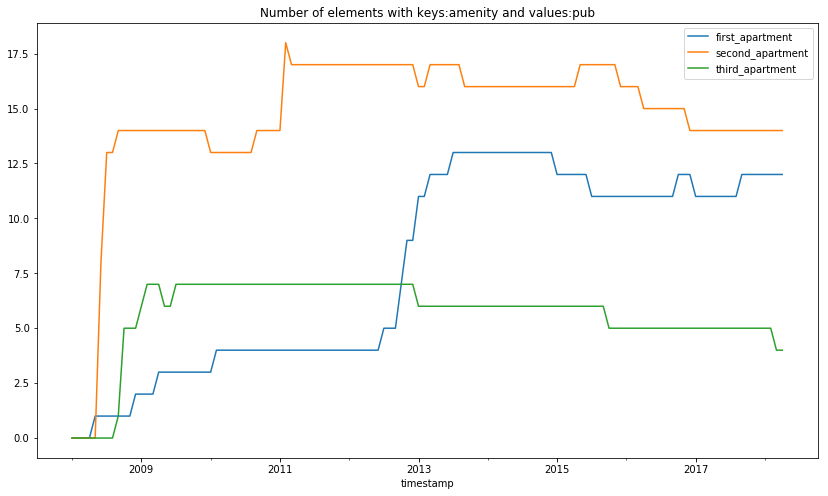

In [11]:
df.plot(x="timestamp", y=df.columns[1:4], figsize=(14,8), title="Number of elements with keys:{} and values:{}".format(keys,values))